In [ ]:
# ──────────────────────────────────────────────────────────────
# Headers like this are in the code because keep things chunked
# "If my commit messages don't have emojis, how would you know how I feel?"
# - ProgrammersAreAlsoHuman, '0.1x engineers'
# ──────────────────────────────────────────────────────────────

"""
This code trains several models to perform a 3SUM task generated
by https://github.com/JacobPfau/fillerTokens/tree/master, comparing
model training curves, attention maps, and test set performance in
order to highlight the role of filler tokens.


I plan to use these training runs:
    1) CoT as filler (filler unmasked)
    2) Dots as filler (filler masked out)
    3) Low entropy tokens as filler (filler masked out)
    4) High entropy tokens as filler (filler masked out)
    5) Direct-to-answer

This allows for
    1) A high-quality gold standard for the model, direct-to-answer.  Not very related to my experiment but a super-baseline.
    2) Progressively more difficult tasks to pull out some sort of linear relationship (heavily relies on the assumption that I've picked tokens which are linear along some axis, but these *were* calculated via the entropix repo as progressively more-difficult-to-predict tokens.  Need to formalize this more but for now not worth the time).  Keep the experiment simple as there are so many possible experiments.


Outline of data pipeline (in other file) for clarity:
1) We generate three kinds of samples, direct, CoT and punct:
    533 569 530 814 A False
    371 578 006 519 P 1- 4 0- 7 3- 7- 4- 4 5- 6 A True
    873 545 827 245 P . . . . . . . . . . . . . A False
    # Note that this is prompt followed by answer in the same string
    # Answers are one word long (True/False), so
      future [-1], len(prompt)-1, are referring to this
2) Turn that into a HF dataset which has two columns:
    a) input_ids: tokenized full prompts
    b) labels: same except -100-masked everywhere but answer
"""


"\nThis code trains several models to perform a 3SUM task generated\nby https://github.com/JacobPfau/fillerTokens/tree/master, comparing\nmodel training curves, attention maps, and test set performance in\norder to highlight the role of filler tokens.\n\n\nI plan to use these training runs:\n    1) CoT as filler (filler unmasked)\n    2) Dots as filler (filler masked out)\n    3) Low entropy tokens as filler (filler masked out)\n    4) High entropy tokens as filler (filler masked out)\n    5) Direct-to-answer\n\nThis allows for\n    1) A high-quality gold standard for the model, direct-to-answer.  Not very related to my experiment but a super-baseline.\n    2) Progressively more difficult tasks to pull out some sort of linear relationship (heavily relies on the assumption that I've picked tokens which are linear along some x axis, but these *were* calculated via the entropix repo as progressively more-difficult-to-predict tokens.  Need to formalize this more but for now not worth the t

# Prep

In [ ]:
# ──────────────────────────────────────────────────────────────
# Imports
# ──────────────────────────────────────────────────────────────
# Try/except to avoid repeated install
try:
    import bitsandbytes as bnb
except:
    # This takes a while but at the moment I think this is the minimal necessary to get all the stuff to work together:
    !pip uninstall -y torch torchvision torchaudio -q
    !pip install --index-url https://download.pytorch.org/whl/cu121 \
        torch==2.3.0 torchvision torchaudio
    !pip install flash-attn==2.7.4.post1 --no-build-isolation
    !pip install -U bitsandbytes==0.45.5
    !pip install -U "fsspec==2025.3.2"
    !pip install -U transformers accelerate peft datasets tqdm

import gc
import json
import os
import tempfile
import pathlib
import shutil
import re
import subprocess
import shlex
import warnings
from pathlib import Path
from glob import glob
from functools import partial
from types import SimpleNamespace as ns
from collections import Counter
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset, load_from_disk
from google.colab import drive
from huggingface_hub import notebook_login
from peft import LoraConfig, get_peft_model, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    TrainerCallback
)
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import MultipleLocator


In [ ]:
# ──────────────────────────────────────────────────────────────
# Global variables and namespace for the run
# ──────────────────────────────────────────────────────────────
# Run namespace
presets = {
    'cot': ns(
        runtype='cot',
        save_tag='base',
        filler_tok=None
    ),
    'direct': ns(
        runtype='direct',
        save_tag='base',
        filler_tok=None
    ),
    'punct_space-dot': ns(
        runtype='punct',
        save_tag='space-dot',
        filler_tok=' .'
    ),
    'punct_dot': ns(
        runtype='punct',
        save_tag='dot',
        filler_tok='.'
    ),
    'punct_space-comma': ns(
        runtype='punct',
        save_tag='space-comma',
        filler_tok=' ,'
    ),
    'filler_ctrl14': ns(
        runtype='filler',
        save_tag='ctrl14',
        filler_tok=b'\x14'.decode('latin-1')
    ),
    'filler_space-neu': ns(
        runtype='filler',
        save_tag='space-neu',
        filler_tok=' neu'
    ),
    'filler_space-big': ns(
        runtype='filler',
        save_tag='space-big',
        filler_tok=' big'
    ),
    'names_Peter': ns(
        runtype='names',
        save_tag='Peter',
        filler_tok='Peter'
    ),
    'names_Albert': ns(
        runtype='names',
        save_tag='Albert',
        filler_tok='Albert'
    ),
    'names_Anna': ns(
        runtype='names',
        save_tag='Anna',
        filler_tok='Anna'
    ),
    'chemistry_space-ion': ns(
        runtype='chemistry',
        save_tag='space-ion',
        filler_tok=' ion'
    ),
    'chemistry_space-alk': ns(
        runtype='chemistry',
        save_tag='space-alk',
        filler_tok=' alk'
    ),
    'chemistry_space-electron': ns(
        runtype='chemistry',
        save_tag='space-electron',
        filler_tok=' electron'
    ),
    'math_space-pi': ns(
        runtype='math',
        save_tag='space-pi',
        filler_tok=' pi'
    ),
    'math_space-sqrt': ns(
        runtype='math',
        save_tag='space-sqrt',
        filler_tok=' sqrt'
    ),
    'math_space-cos': ns(
        runtype='math',
        save_tag='space-cos',
        filler_tok=' cos'
    ),
    'drawing_space-ink': ns(
        runtype='drawing',
        save_tag='space-ink',
        filler_tok=' ink'
    ),
    'drawing_space-brush': ns(
        runtype='drawing',
        save_tag='space-brush',
        filler_tok=' brush'
    ),
    'drawing_space-paint': ns(
        runtype='drawing',
        save_tag='space-paint',
        filler_tok=' paint'
    ),
}

# Paths
BASE_DIR = Path("/content/drive/MyDrive/Colab_Files/repurposed_tokens")
MODEL_ID = "meta-llama/Llama-3.2-1B"
MODEL_NAME = MODEL_ID.rsplit("/", 1)[-1]

def data_dir(runtype: str, save_tag: str|None) -> Path:
    return BASE_DIR / "data" / runtype / (save_tag or "base")

def model_dir(runtype: str, save_tag: str|None) -> Path:
    return BASE_DIR / "models" / MODEL_NAME / runtype / (save_tag or "base") / LORA_TARGET

def tokenized_paths(runtype: str, save_tag: str|None) -> tuple[Path, Path]:
    d = data_dir(runtype, save_tag)
    return d / "train_tokenized", d / "test_tokenized"

def artifact_paths(runtype: str, save_tag: str|None) -> dict[str, Path]:
    m = model_dir(runtype, save_tag)
    return {
        "model_dir": m,
        "checkpoints": m / "checkpoints",
        "train_log_csv": m / "train_log.csv",
        "run_meta_json": m / "run_meta.json",
    }

# GPU setup for T4
gpu = ns(
    torch_dtype=torch.float16,
    bnb_4bit_compute_dtype=torch.float16,
    attn_implementation='sdpa',
    bf16=False,  # Not possible on T4s
    fp16=True,
    fp16_full_eval=True,
    grad_ckpt=False,
    tf32=False  # Not possible on T4s
)

# Training
TAU = .8
AUC_N = 300
# Note we want to preserve original routing so mlp should be the only target.
LORA_TARGET = 'mlp'


In [ ]:
# ──────────────────────────────────────────────────────────────
# Github, Drive, and HF setup
# ──────────────────────────────────────────────────────────────
%cd /content

drive.flush_and_unmount()
if os.path.exists('/content/drive') and not os.path.islink('/content/drive'):
    shutil.rmtree('/content/drive')
drive.mount('/content/drive', force_remount=True)

notebook_login()
os.environ['HF_HOME'] = '/content/drive/MyDrive/HF_cache'


/content
Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# Tokenizer and model tools

In [ ]:
# Tokenizer
# Note: We only want loss on the answer token and eos, because we want it to use the periods how it wants, not generate them.
tok = AutoTokenizer.from_pretrained(
    os.path.join(BASE_DIR, 'tokenizer'),
    use_fast=True
)

tok.pad_token = tok.eos_token
tok.cot_begin_id = tok(" P", add_special_tokens=False)["input_ids"][0]
tok.cot_end_id = tok(" A", add_special_tokens=False)["input_ids"][0]
tok.true_id = tok(" True", add_special_tokens=False)["input_ids"][0]
tok.false_id = tok(" False", add_special_tokens=False)["input_ids"][0]


# Config/Collator for both finetune AND eval runs
# Bnb config
# 4 bit
bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=gpu.bnb_4bit_compute_dtype,
)
# 8 bit:
# bnb_cfg = BitsAndBytesConfig(
#     load_in_8bit=True,
#     llm_int8_threshold=6.0, # CHANGE IF OVERFLOW
#     llm_int8_enable_fp32_cpu_offload = False
# )

def pad_batch(batch, pad_id):
    return pad_sequence(
        [seq if isinstance(seq, torch.Tensor)
        else torch.tensor(seq) for seq in batch],
        batch_first=True,
        padding_value=pad_id
    )

def pad_and_mask(examples):
    input_ids = pad_batch([ex['input_ids'] for ex in examples],tok.pad_token_id)
    labels = pad_batch([ex['labels'] for ex in examples], -100)
    return {
        'input_ids': input_ids,
        'labels': labels,
        'attention_mask': (input_ids != tok.pad_token_id).long()
    }


# Callback
class EarlyStopCallback(TrainerCallback):
    def __init__(self, target_acc, patience):
        self.target_acc = target_acc
        self.patience = patience
        self.streak = 0
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        acc = (metrics or {}).get("eval_accuracy")
        if acc is None: return control
        self.streak = self.streak + 1 if acc >= self.target_acc else 0
        if self.streak >= self.patience:
            control.should_training_stop = True
            control.should_save = True
        return control


# Finetuning

In [ ]:
def run_all_missing(
    steps: int = AUC_N,
    eval_every: int = 5,
    target_acc: float = 1.0,
    patience: int = 2,
    run_n: int = 0
):
    made, skipped = 0, 0
    for key, cfg_i in presets.items():
        # Memory cleanup to limit OOM.  WILL still go oom after 6+ maybe
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
        torch._dynamo.reset()

        # Directories
        train_tok, test_tok = tokenized_paths(cfg_i.runtype, cfg_i.save_tag)
        assert os.path.exists(train_tok) and os.path.exists(test_tok), \
            f"Missing tokenized datasets for {key}: {train_tok} / {test_tok}"

        arts = artifact_paths(cfg_i.runtype, cfg_i.save_tag)
        log_path = Path(arts["train_log_csv"]).with_name(
            f"{Path(arts['train_log_csv']).stem}_{run_n}.csv"
        )
        os.makedirs(arts["model_dir"], exist_ok=True)

        if os.path.exists(log_path):
            try:
                df = pd.read_csv(log_path)
                max_step = df["step"].max() if "step" in df.columns else 0
            except Exception:
                max_step = 0

            if max_step >= 30:
                print(f"{key}: skipped {arts["model_dir"]}; {max_step} steps")
                skipped += 1
                continue
            else:
                print(f"{key}: running {arts["model_dir"]}; {max_step} steps")

        # Tokenizer and data
        if getattr(cfg_i, "filler_tok", None):
            enc = tok(cfg_i.filler_tok, add_special_tokens=False)
            tok.filler_id = torch.tensor(enc["input_ids"][0])
        else:
            if hasattr(tok, "filler_id"):
                del tok.filler_id

        tr = load_from_disk(str(train_tok))
        te = load_from_disk(str(test_tok))
        tiny_eval = te.shuffle(seed=42).select(range(min(32, len(te))))

        # Model
        base = AutoModelForCausalLM.from_pretrained(
            MODEL_ID,
            quantization_config=bnb_cfg,
            torch_dtype=gpu.torch_dtype,
            device_map={'': 0},
            attn_implementation=gpu.attn_implementation,
        )
        base.resize_token_embeddings(len(tok))
        base.config.use_cache = False
        torch.backends.cuda.matmul.allow_tf32 = gpu.tf32

        targets_map = {
            'attn': ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
            'mlp':  ['gate_proj', 'up_proj', 'down_proj'],
            'both': ['q_proj', 'k_proj', 'v_proj', 'o_proj',
                     'gate_proj', 'up_proj', 'down_proj'],
        }
        lora_cfg = LoraConfig(
            r=8, lora_alpha=32, target_modules=targets_map[LORA_TARGET],
            lora_dropout=0.05, bias='lora_only'
        )
        model = get_peft_model(base, lora_cfg)

        # Training
        def compute_metrics(eval_preds):
            logits, labels = eval_preds
            sl = logits[:, :-1, :]
            yl = labels[:, 1:]
            m = yl != -100
            return {"accuracy": accuracy_score(yl[m], sl.argmax(-1)[m])}

        args = TrainingArguments(
            output_dir=str(Path(arts['model_dir'])/f"checkpoints_run{run_n}"),
            label_names=['labels'],
            num_train_epochs=1,
            per_device_train_batch_size=1,  # These two can go up for indiv
            gradient_accumulation_steps=1,
            learning_rate=3e-4,
            lr_scheduler_type='cosine',
            max_steps=steps,
            warmup_steps=int(0.1 * steps),
            bf16=gpu.bf16,
            fp16=gpu.fp16,
            fp16_full_eval=gpu.fp16_full_eval,
            optim='adamw_bnb_8bit',
            logging_steps=2,
            eval_strategy='steps',
            eval_steps=eval_every,
            load_best_model_at_end=True if run_n == 0 else False,
            metric_for_best_model='eval_accuracy',
            greater_is_better=True,
            save_strategy='no',
            report_to='none',
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=tr,
            eval_dataset=tiny_eval,
            data_collator=pad_and_mask,
            compute_metrics=compute_metrics,
        )

        trainer.add_callback(EarlyStopCallback(target_acc, patience))
        trainer.train()

        # Out
        if run_n == 0:
            model.save_pretrained(arts['model_dir'], safe_serialization=True)

        log = pd.DataFrame(trainer.state.log_history)
        log["runtype"] = cfg_i.runtype
        log["save_tag"] = cfg_i.save_tag
        log["run_n"] = run_n
        log.to_csv(log_path, index=False)

        json.dump(
            {"runtype": cfg_i.runtype, "save_tag": cfg_i.save_tag,
             "lr": args.learning_rate, "max_steps": args.max_steps,
             "warmup_steps": args.warmup_steps, "lora_target": LORA_TARGET},
            open(arts["run_meta_json"], "w")
        )
        print(f"Wrote {log_path}")
        made += 1

    print(f"\nLoop completed; created {made} and skipped {skipped}.")

# run
run_all_missing(steps=AUC_N, eval_every=5, run_n = 1)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!
The model is already on multiple devices. Skipping the move to device specified in `args`.


Step,Training Loss,Validation Loss


# Evaluation and Visualization

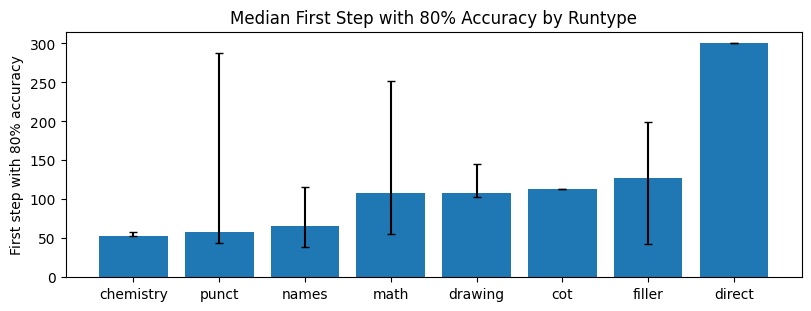

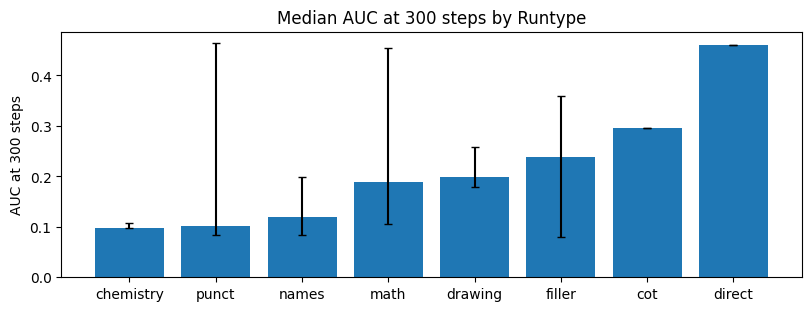

In [ ]:
# ──────────────────────────────────────────────────────────────
# Training Speed Summary (aggregate across runs)
# ──────────────────────────────────────────────────────────────
fig_dir = Path(BASE_DIR)/"figures"
fig_dir.mkdir(parents=True, exist_ok=True)

# Steps to hit first-pass rate
def fps_at_tau(df, tau=0.80):
    g = df.dropna(subset=["eval_accuracy"]).sort_values("step")
    if g.empty: return np.inf
    accuracy_values = g["eval_accuracy"].to_numpy()
    step_values = g["step"].to_numpy()
    i = np.searchsorted(accuracy_values, tau)
    if i==0 or i>=len(accuracy_values): return np.inf
    # linear interpolation between (s[i-1],a[i-1]) and (s[i],a[i])
    return float(step_values[i-1] + (tau-accuracy_values[i-1]) *
                 (step_values[i]-step_values[i-1]) /
                 (accuracy_values[i]-accuracy_values[i-1]))

# AUC of accuracy over steps
def auc_at_N(df, N):
    g = df.dropna(subset=["eval_accuracy"]).sort_values("step")
    if g.empty: return np.nan
    x = np.clip(g["step"].to_numpy(), 0, N)
    y = g["eval_accuracy"].to_numpy()
    keep = np.r_[True, np.diff(x) > 0] & (x <= N)  # remove repeated steps
    return float(np.trapezoid(y[keep], x[keep]) / max(N,1))

# Aggregate training speed across runs
rows = []
pattern = rf"{BASE_DIR}/models/{MODEL_NAME}/**/mlp/**/train_log*.csv"
for path in glob(pattern, recursive=True):
    df = pd.read_csv(path)
    match = re.search(r"/(cot|direct|punct|filler|names|chemistry|math|drawing)"
                      r"(?:/([^/]+))?/", path)
    if not match:
        continue
    runtype, tag = match.group(1), (match.group(2) or "base")
    rows.append(dict(
        runtype=runtype, save_tag=tag, path=path,
        fps=fps_at_tau(df, TAU),
        auc=auc_at_N(df, AUC_N)
    ))

agg = pd.DataFrame(rows)
agg["fps"] = np.where(np.isfinite(agg["fps"]), agg["fps"], AUC_N)
agg.to_csv(fig_dir/"speed_per_filler.csv", index=False)

# Summary statistics
summary = (agg.replace(np.inf, np.nan)
              .groupby("runtype", as_index=False)
              .agg(median_fps=("fps","median"),
                   median_auc=("auc","median")))
summary.to_csv(fig_dir/"speed_summary.csv", index=False)

# FPS bar plot
g = agg.groupby("runtype", as_index=True)["fps"]
fps_med = g.median()
fps_lo  = g.quantile(0.025)
fps_hi  = g.quantile(0.975)

order_fps = fps_med.sort_values().index.tolist()
x_fps = np.arange(len(order_fps))
y = fps_med.loc[order_fps].values
yerr = np.vstack([
    y - fps_lo.loc[order_fps].values,
    fps_hi.loc[order_fps].values - y
])

plt.figure(figsize=(8, 3), constrained_layout=True)
plt.bar(x_fps, y, yerr=yerr, capsize=3, linewidth=0)
plt.xticks(x_fps, order_fps, rotation=0)
plt.ylabel(f"First step with {int(TAU*100)}% accuracy")
plt.title("Median First Step with 80% Accuracy by Runtype")
# plt.savefig(fig_dir / "fig1_fps_bars.png", dpi=300)
plt.show()
plt.close()

# AUC bar plot
g = agg.groupby("runtype", as_index=True)["auc"]
auc_med = g.median()
order_auc = auc_med.sort_values().index.tolist()
x_auc = np.arange(len(order_auc))
y = auc_med.loc[order_auc].values
yerr = np.vstack([
    y - g.quantile(0.025).loc[order_auc].values,
    g.quantile(0.975).loc[order_auc].values - y
])

plt.figure(figsize=(8, 3), constrained_layout=True)
plt.bar(x_auc, y, yerr=yerr, capsize=3, linewidth=0)
plt.xticks(x_auc, order_auc, rotation=0)
plt.ylabel(f"AUC at {AUC_N} steps")
plt.title(f"Median AUC at {AUC_N} steps by Runtype")
# plt.savefig(fig_dir / "fig1b_auc_bars.png", dpi=300)
plt.show()
plt.close()


In [ ]:
print(y)

[0.09739583 0.10208333 0.11927083 0.1890625  0.1984375  0.23854167
 0.2953125  0.45963542]


# Individual plots/evaluation

In [ ]:
# Choose the run type
run_cfg = presets['names_Peter']
train_tok, test_tok = tokenized_paths(run_cfg.runtype, run_cfg.save_tag)
MODEL_DIR = model_dir(run_cfg.runtype, run_cfg.save_tag)
arts = artifact_paths(run_cfg.runtype, run_cfg.save_tag)

if getattr(run_cfg, "filler_tok", None):
    tok.filler_id = torch.tensor(tok(run_cfg.filler_tok, add_special_tokens=False)["input_ids"][0])
elif hasattr(tok, "filler_id"):
    del tok.filler_id

train_ds = load_from_disk(str(train_tok))
test_ds = load_from_disk(str(test_tok))


In [ ]:
# ──────────────────────────────────────────────────────────────
# Load the finetuned model and LoRA adapter
# ──────────────────────────────────────────────────────────────
# Base model
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_cfg,
    torch_dtype='auto',
    device_map={'': 0},
    attn_implementation='eager',  # for pure accuracy eval we can do sdpa on T4
)

# Finetuned LoRA
model = PeftModel.from_pretrained(
    base_model,
    MODEL_DIR,
    is_trainable=False,
    torch_dtype='auto',
    device_map={'': 0},
)

# Merge
model = model.merge_and_unload()
model.eval()

# Compile
# QuantLinear isn't traceable by Torch-Dynamo so we can't do this:
# model = torch.compile(model, mode="reduce-overhead")
model.config.pad_token_id = tok.pad_token_id


/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


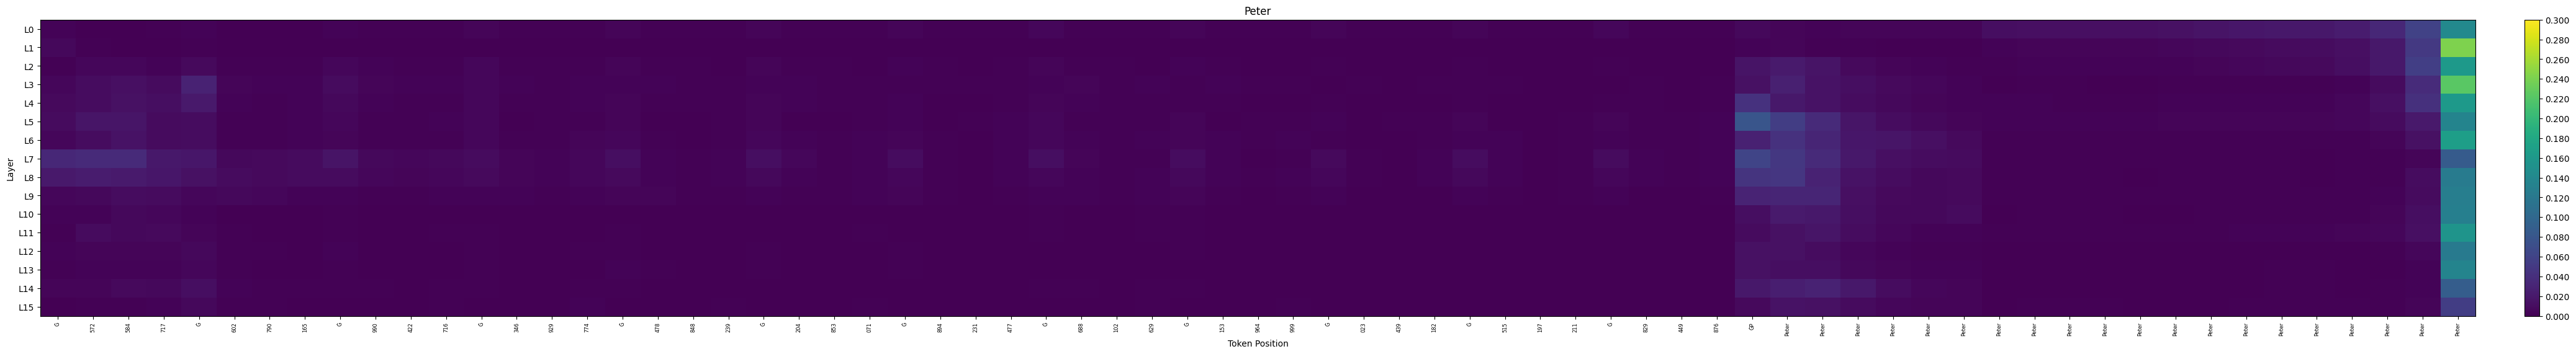

In [ ]:
# ──────────────────────────────────────────────────────────────
# Heatmap - INDIVIDUAL
# ──────────────────────────────────────────────────────────────
def heatmap_data(model, dataloader, *, tok, answer_pos_fn=None):
    """Per-layer attention received by each token position."""
    mats = []
    tokens_reference = None

    with torch.no_grad():
        for batch in dataloader:
            # Forward pass with attention outputs
            out = model(
                **{k: v.to(model.device) for k, v in batch.items()},
                use_cache=False,
                output_attentions=True
            )
            # Average attention over heads
            attn_layers = [att.mean(1) for att in out.attentions]  # (B,Q,K)
            batch_size = batch["input_ids"].shape[0]

            for i in range(batch_size):
                # Determine answer position
                if answer_pos_fn is not None:
                    answer_position = answer_pos_fn(batch, i)
                else:
                    # Default to first unmasked label position
                    answer_position = (batch["labels"][i] != -100).nonzero(as_tuple=True)[0].item()

                sequence_length = batch["attention_mask"][i].sum().item()

                # Get attention paid to each token by the answer token
                attn_by_layer = [
                    layer[i][answer_position, 1:sequence_length].cpu()
                    for layer in attn_layers
                ]
                row = torch.stack(attn_by_layer)
                row /= row.sum(-1, keepdim=True).clamp_min(1e-9)
                mats.append(row)

                if (tokens_reference is None
                    or (sequence_length-1) > len(tokens_reference)):
                    tokens_reference = tok.convert_ids_to_tokens(
                        batch["input_ids"][i][1:sequence_length].tolist(),
                        skip_special_tokens=False
                    )

    # Stack all matrices and average across batch
    max_len = max(row.size(1) for row in mats)
    mats = [F.pad(row, (0, max_len - row.size(1)), value=float('nan'))
            for row in mats]
    mat = torch.nanmean(torch.stack(mats, 0), dim=0)
    return mat, tokens_reference


def plot_heatmap(mat, *, title="", xticks=None, save_dir=None):
    # Convert to numpy
    if hasattr(mat, "cpu"):
        mat = mat.float().cpu().numpy()

    layers, seq_length = mat.shape
    fig_width, fig_height = seq_length * 0.6, layers * 0.35

    plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
    plt.imshow(mat, aspect="auto", vmin=0.0, vmax=0.3)

    # Colorbar
    cbar = plt.colorbar(pad=0.02)
    cbar.locator = MultipleLocator(0.02)
    cbar.ax.yaxis.set_major_formatter("{x:.3f}")

    # Axes and labels
    plt.yticks(range(layers), [f"L{i}" for i in range(layers)])
    plt.xticks(
        range(seq_length),
        xticks if xticks is not None else range(seq_length),
        rotation=90, fontsize=6
    )
    plt.xlabel("Token Position")
    plt.ylabel("Layer")
    if title:
        plt.title(title)

    # Save
    output_dir = Path(save_dir) if save_dir is not None else Path(MODEL_DIR)
    output_dir.mkdir(parents=True, exist_ok=True)
    image_path = output_dir / "heatmap.png"
    array_path = image_path.with_suffix(".npy")

    # plt.savefig(image_path, dpi=300)
    # np.save(array_path, mat)
    plt.show()
    plt.close()


# Run
mat, tokens = heatmap_data(
    model,
    torch.utils.data.DataLoader(
        test_ds.select(range(200)),
        batch_size=8,
        collate_fn=pad_and_mask
    ),
    tok=tok
)

# Select sections
tmp_ids = tok.convert_tokens_to_ids(tokens)
beg = tmp_ids.index(tok.cot_begin_id)
end = tmp_ids.index(tok.cot_end_id)
selected = list(range(beg + 7)) + list(range(end - 14, end))

# Plot
plot_heatmap(
    mat[:, selected],
    xticks=[tokens[i] for i in selected],
    title=run_cfg.save_tag,
    save_dir=MODEL_DIR
)


In [ ]:
print(image_path)

NameError: name 'image_path' is not defined

In [ ]:
# ──────────────────────────────────────────────────────────────
# Heatmap - AVGD ACROSS RUNS (requires having individual ready)
# ──────────────────────────────────────────────────────────────
# Collect heatmaps
run_root = Path(f"{BASE_DIR}/models/{MODEL_NAME}")
heatmaps = []
for npy in glob(str(run_root / "**/heatmap.npy"), recursive=True):
    matrix = np.load(npy)
    assert matrix.shape == heatmaps[0].shape, f"Shapes don't match in {npy}"
    heatmaps.append(matrix.astype(np.float32))

# Average
grand = np.stack(heatmaps).mean(0)  # (layers, seq_len)

# Plot
plot_heatmap(
    grand,
    title=f"{run_cfg.runtype or 'all'}_mean",
    xticks=[tokens[i] for i in selected],
    save_dir=run_root,
)


IndexError: list index out of range

In [ ]:
# ──────────────────────────────────────────────────────────────
# Attention hook
# ──────────────────────────────────────────────────────────────
def _record_attn(layer_idx, module, input, output):
    """Writes (B, H) into CURRENT_FILL (B, L, H)"""
    attn_probs = output[1]  # (B, H, Q, K)

    if run_cfg.filler_tok is None:
        # (1) Average attention across all query-key pairs:
        # fill = attn_probs.mean((-2, -1))  # (B,H)

        # (2) Avg each query's strongest attention weight across all queries:
        #     - bright for sharp and dark for diffuse
        # fill = attn_probs.max(-1).values.mean(-1)  # (B,H)

        # (3) Attention at only the answer-token query:
        ans_mask = (LABELS_THIS_BATCH != -100)[:, None, :, None]  # (B,1,Q,1)
        fill = (attn_probs * ans_mask).max(-1).values.mean(-2)  # sharpness
    else:
        filler_mask = torch.isin(
            TOKEN_IDS_THIS_BATCH.to(model.device),
            tok.filler_id.to(model.device)
        )[:, None, None, :attn_probs.size(-1)]  # (B,1,1,K')
            # B matches
            # 1 broadcasts across all heads
            # 1 broadcasts across all query positions
            # K matches THIS pad, since we have dynamic padding, can't use K

        # Compute mean over query dimension
        #     - Mean attention per filler token, then avg over queries
        denom = filler_mask.sum(-1).clamp_min(1).float()  # (B,1,1,K)
        fill = (attn_probs*filler_mask).sum(-1).div(denom).mean(-1)  # (B,H)

    CURRENT_FILL[:, layer_idx, :] = fill.cpu()
    del attn_probs
    torch.cuda.empty_cache()

# Attach to every layer
def attach_attention_hooks(model):
    # return [
    #     block.self_attn.register_forward_hook(
    #         partial(_record_attn, layer_idx)
    #     ) for layer_idx, block in enumerate(model.model.layers)
    # ]
    # Trying this to avoid a memory leak; long story.
    return [
        block.self_attn.register_forward_hook(
            lambda m,i,o,idx=layer_idx: _record_attn(idx, m, i, o)
        ) for layer_idx, block in enumerate(model.model.layers)
    ]

L = model.config.num_hidden_layers
H = model.config.num_attention_heads
handles = attach_attention_hooks(model)


Corpus filler rate: 67.033%


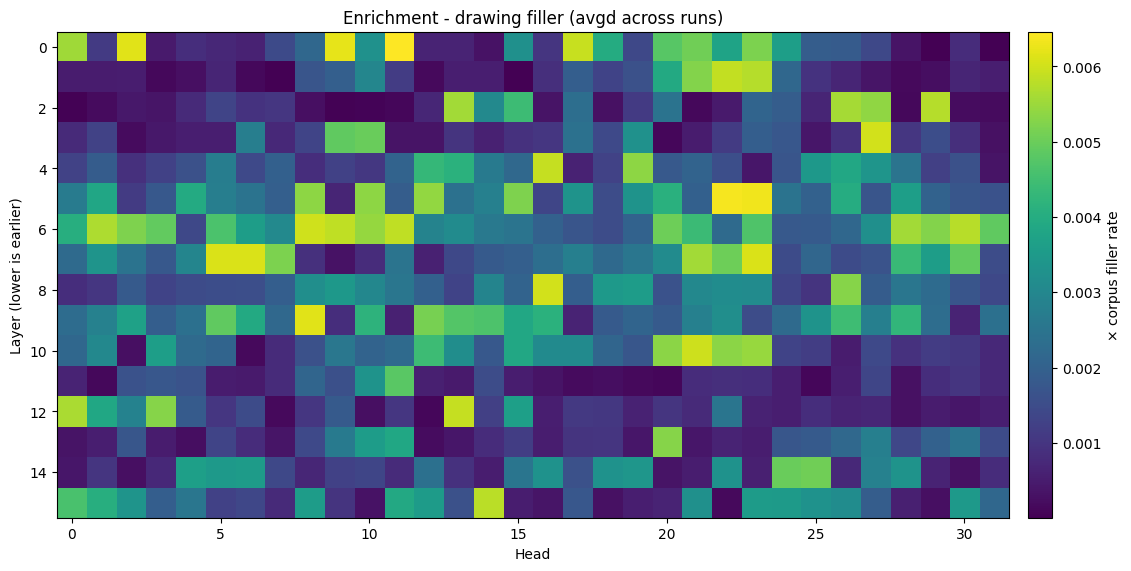

In [ ]:
# ──────────────────────────────────────────────────────────────
# Attention logging and visualization
# ──────────────────────────────────────────────────────────────
def get_raw_attention(dataloader):
    global TOKEN_IDS_THIS_BATCH, CURRENT_FILL
    ATTN_BUCKET.clear()

    with torch.no_grad():
        for batch in tqdm(dataloader):
            TOKEN_IDS_THIS_BATCH = batch["input_ids"].to(model.device)  # (B, S)
            global LABELS_THIS_BATCH
            LABELS_THIS_BATCH = batch["labels"].to(model.device)

            B = TOKEN_IDS_THIS_BATCH.size(0)  # L and H are global
            CURRENT_FILL = torch.zeros(B, L, H)  # (B, L, H)
                # Remember CURRENT_FILL is filled by the hooks we set
            _ = model(
                **{k: v.to("cuda") for k, v in batch.items()},
                use_cache=False,
                output_attentions=True
            )
            ATTN_BUCKET.append(CURRENT_FILL.cpu())

    raw_attn = torch.cat(ATTN_BUCKET, dim=0)  # (N, L, H)

    # Memory leak fix:
    del ATTN_BUCKET[:]  # clear
    torch.cuda.empty_cache()

    return raw_attn

def calculate_enrichment(raw_attn):
    """Adjusts the attention for the percentage of filler tokens
    in the ds otherwise the attention mass is biased
    """
    # Calculate the filler rate
    n_fill, n_total = 0, 0
    for ex in test_ds:
        ids = ex["input_ids"]
        n_total += len(ids)
        n_fill += torch.isin(torch.tensor(ids, device=model.device),
                             tok.filler_id.to(model.device)).sum().item()

    fill_rate = n_fill / n_total if n_total else 0.0
    print(f"Corpus filler rate: {fill_rate:.3%}")
        # THIS MIGHT BE WRONG FOR DIRECT?  BECAUSE THERES NO FILLER TO DILUTE  not sure what I'm looking for with direct

    # Calculate the enrichment
    prob_to_fill = raw_attn.mean(dim=0)  # (L, H)
    return prob_to_fill / max(fill_rate, 1e-9)

def plot_attn_heat(mat, title=""):
    # Width per head, height per layer (matches previous cell's logic)
    fig, ax = plt.subplots(
        figsize=(mat.size(1)*0.35, mat.size(0)*0.35),
        constrained_layout=True
    )
    im = ax.imshow(mat.numpy(), aspect="auto", vmin=0.0, vmax=0.02)  # TUNE?
    ax.set_xlabel("Head")
    ax.set_ylabel("Layer (lower is earlier)")
    ax.set_title(title)
    fig.colorbar(im, ax=ax, pad=0.02)
    plt.show()

# Get raw attention
ATTN_BUCKET = []
raw_attn = get_raw_attention(
    torch.utils.data.DataLoader(
        test_ds.shuffle().select(range(200)),
        batch_size=8,
        shuffle=False,
        collate_fn=pad_and_mask,
    )
)

# Convert to enrichment
    # I regret writing mean_attn because I don't even think I want these plots yet for direct runs.  Might be used later, I guess.  But for run = 'direct' I'm just moving to accuracy.
if run_cfg.filler_tok is not None:
    enr = calculate_enrichment(raw_attn)
    print("raw max:", raw_attn.mean(0).max().item())
    print("enr max:", enr.max().item())
    plot_attn_heat(enr, f"Enrichment - {run_cfg.save_tag}")
    np.save(os.path.join(MODEL_DIR, "enrichment.npy"), enr.numpy())
else:
    mean_attn = raw_attn.mean(dim=0)
    print("raw max:", mean_attn.max().item())
    plot_attn_heat(mean_attn, f"Mean Attention - {run_cfg.save_tag}")
    np.save(os.path.join(MODEL_DIR, "mean_attn.npy"), mean_attn.numpy())


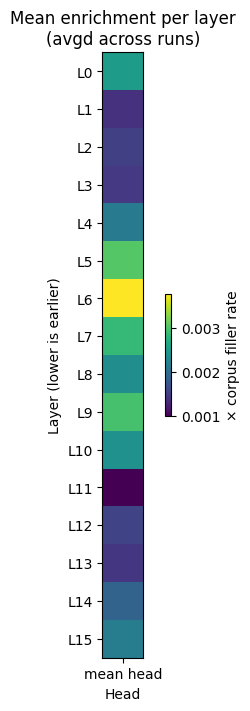

In [ ]:
if run_cfg.filler_tok is not None:
    layer_means = enr.mean(dim=1)  # (L, H) to (L,)
    plt.figure(figsize=(2, 7), constrained_layout=True)
    plt.imshow(layer_means[:, None].numpy(), aspect='auto', vmin=0.0, vmax=0.02)
    cbar = plt.colorbar(pad=0.02)
    cbar.locator = MultipleLocator(0.02)
    cbar.set_ticks(np.arange(0.0, 0.005, 0.001))

    plt.yticks(range(enr.size(0)), [f"L{l}" for l in range(enr.size(0))])
    plt.xticks([0], ["mean head"])
    plt.xlabel("Head")
    plt.ylabel("Layer (lower is earlier)")
    plt.title("Mean enrichment per layer")
    plt.show()


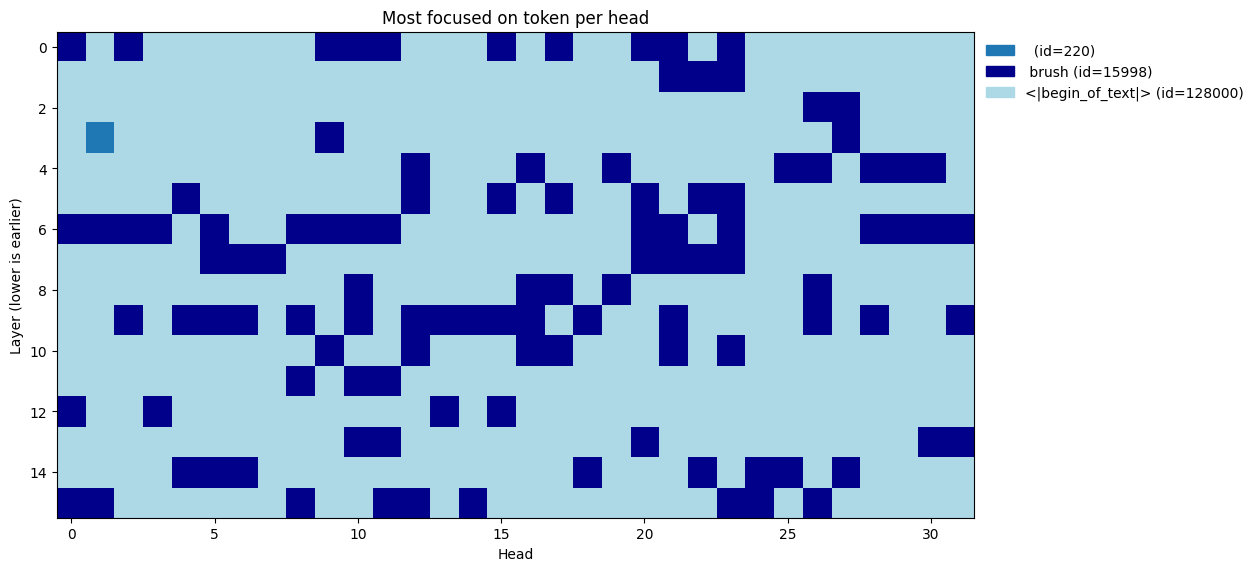

In [ ]:
# Major token attended-to per head/layer categorical heat-map
# with fixed colors for special token-ids

# Collect full attentions so raw_attn is 4-D (N,L,H,S)
dl = torch.utils.data.DataLoader(
    test_ds.shuffle().select(range(200)),
    batch_size=8,
    shuffle=False,
    collate_fn=pad_and_mask,
)
attn_chunks, id_chunks = [], []
with torch.no_grad():
    for batch in dl:
        out = model(**{k: v.to(model.device) for k, v in batch.items()},
                     use_cache=False, output_attentions=True)
        attn_chunks.append(torch.stack(out.attentions, dim=1).mean(-2).cpu())  # (B,L,H,S)
        id_chunks.append(batch["input_ids"])
raw_attn = torch.cat(attn_chunks, 0)  # (N,L,H,S)
ids_all = torch.cat(id_chunks, 0)  # (N,S)

N, L, H, S = raw_attn.shape
vocab = max(tok.vocab_size, ids_all.max().item() + 1)
attn_to_tok = torch.zeros(L, H, vocab, device=raw_attn.device)
for t in torch.unique(ids_all):
    mask = (ids_all == t).float()  # (N,S)
    attn_to_tok[:, :, t] = (raw_attn * mask[:, None, None, :]).sum(-1).mean(0)

maj_tok = attn_to_tok.argmax(-1).cpu()  # (L,H)

# Fixed colors for token ids
color_by_id = {
    128000: "#add8e6",  # (bos) light-blue
    200: "#bfff00",  # (space) light lime-green
    getattr(tok, "filler_id", None): "#00008b",  # dark-blue
    getattr(tok, "eos_token_id", None): "#d3d3d3",  # light-grey
    getattr(tok, "cot_begin_id", None): "#ffa500",  # orange
    getattr(tok, "cot_end_id", None): "#ff69b4",  # pink
}
color_by_id = {k: v for k, v in color_by_id.items() if k is not None}

# Color pallete (reindexing to standardize runs)
cat_ids = torch.unique(maj_tok).tolist()
idx_map = {t: i for i, t in enumerate(cat_ids)}
maj_idx = np.vectorize(idx_map.get)(maj_tok.numpy())  # (L,H)

base_palette = iter(plt.cm.tab20(np.linspace(0, 1, 20)))
colors = [color_by_id.get(t, next(base_palette)) for t in cat_ids]

cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(len(cat_ids) + 1) - 0.5, cmap.N)

# Plot
fig, ax = plt.subplots(
    figsize=(maj_idx.shape[1] * 0.39, maj_idx.shape[0] * 0.35),
    constrained_layout=True,
)
im = ax.imshow(maj_idx, cmap=cmap, norm=norm, aspect="auto")
ax.set_xlabel("Head")
ax.set_ylabel("Layer (lower is earlier)")
ax.set_title("Most focused on token per head")
labels = [tok.decode([t]) if hasattr(tok, "decode")
          else str(t) for t in cat_ids]
patches = [
    mpatches.Patch(color=colors[i], label=f"{labels[i]} (id={cat_ids[i]})")
    for i in range(len(cat_ids))
]
ax.legend(
    handles=patches,
    bbox_to_anchor=(1.00, 1.00),
    loc="upper left",
    frameon=False,
)
plt.show()


In [ ]:
# ──────────────────────────────────────────────────────────────
# Accuracy Eval
# ──────────────────────────────────────────────────────────────
# Remove these if they're still on
for handle in handles:
    handle.remove()

def accuracy(model, testset) -> float:
    """Evaluates model accuracy on test set"""
    # Iterate over test set
    invalid, correct = Counter(), 0
    with torch.no_grad():
        for ex in tqdm(testset, leave=False):
            # Forward the input to get an output
            ids = torch.tensor(
                ex["input_ids"], device=model.device
            ).unsqueeze(0)
            mask = torch.ones_like(ids)

            # Drop the filler tokens
            cut = (ids[0] == tok.cot_begin_id).nonzero(as_tuple=True)[0] + 1
            exp_id = ids[0, -1].item()  # Grab answer
            ids, mask = ids[:, :cut], mask[:, :cut]  # keep prompt and cot_begin

            out = model.generate(
                input_ids=ids,
                attention_mask=mask,
                max_new_tokens=1,
                do_sample=False,
                temperature=None,
                top_p=None,  # Trying these to None because warnings?
            )

            # Check answer
            pred_id = out[0, -1].item()

            # DEBUG
            # print(
            #     f"cut={cut}, "
            #     f"prompt_tail={tok.decode(ids[0,-3:].tolist())!r}, "
            #     f"expected={exp_id} ({tok.decode([exp_id])!r}), "
            #     f"predicted={pred_id} ({tok.decode([pred_id])!r})"
            # )
            # break

            if pred_id == exp_id:
                correct += 1
            elif pred_id not in [tok.true_id, tok.false_id]:
                print(pred_id)
                break
                invalid[pred_id] += 1

    accuracy = correct / len(testset)
    return accuracy, invalid

# this is off now that I don't have puncts/no puncts since that would be handled by aggregating several runs of data, not something we do all at once necessarily?  I guess we can do it all at once after all the models are trained, but it seems useful to have some sort of utility function that works as we go so we can tune the runs.
acc_puncts, invalid_puncts = accuracy(
    model, test_ds.shuffle().select(range(100))
)

print(f"Invalid count: {sum(invalid_puncts.values())}")
print(f"Accuracy: {acc_puncts:.3f}")


  0%|          | 0/100 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


cut=tensor([74], device='cuda:0'), prompt_tail='266308 P', expected=3082→' True', predicted=5726→'RA'
Invalid count: 0
Accuracy: 0.000
